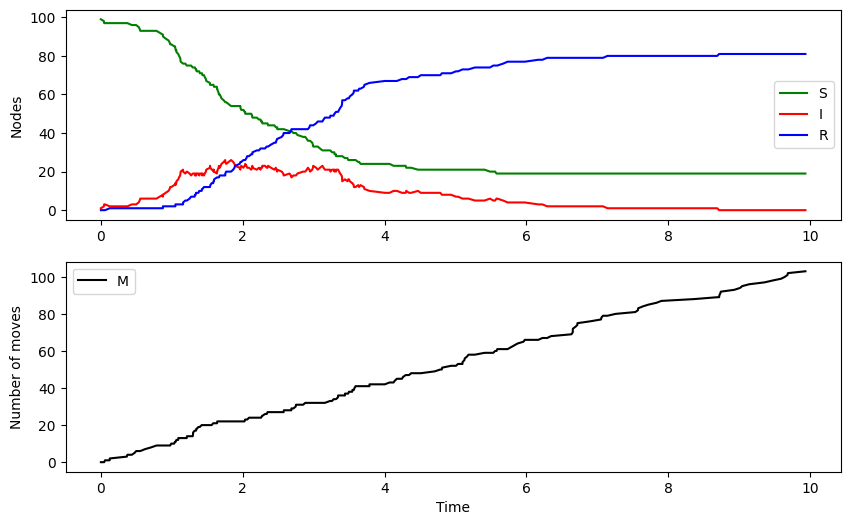

In [12]:
# Gerando o Grafo
import networkx as nx, numpy as np, random as rd

"""G = nx.Graph()
G.add_nodes_from((0,1,2,3,4))
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,0),(0,2),(0,3),(1,3),(1,4),(2,4)])"""

G = nx.random_regular_graph(3,100)

# Criando lista de adjacencia
dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
amatrix = {}
for i in sordic:
    amatrix.update({i:dic[i]})

# Taxa de infecção, recuperação e mobilidade
τ = 2.0
γ = 1.0
m = 0.1

# Condições iniciais
initial_infections = [3]
infected_nodes = initial_infections
tmax = 10
times = [0]
S = [len(amatrix) - len(initial_infections)]
I = [len(initial_infections)]
R = [0]

# Número de vértices vazios
n = 2
empty_nodes = []
while len(empty_nodes) < n:
    r = rd.choice(list(amatrix))
    if r not in empty_nodes and r not in infected_nodes:
        empty_nodes.append(r)
        
# Nós suscetíveis que tem vizinhos infectados
at_risk_nodes = []
for n in infected_nodes:
    viz = list(amatrix[n])
    for v in viz:
        if v not in infected_nodes and v not in empty_nodes:
            at_risk_nodes.append(v)
at_risk_nodes = list(set(at_risk_nodes))

# Armazenando em uma variável as taxas de infecção de cada um dos 
# nós suscetíveis em risco
infection_rate = np.zeros(len(amatrix))
infected_neighbours = []
for n in at_risk_nodes:
    viz = list(amatrix[n])
    n_viz = 0
    for vv in viz:
        if vv in infected_nodes:
            n_viz += 1
    infection_rate[n] = τ*n_viz


# Definindo as taxas de infecção total e recuperação total
total_infection_rate = np.sum(infection_rate)
total_recovery_rate = γ*len(infected_nodes)
total_mobility_rate = m*len(empty_nodes) # Taxa total de mobilidade
total_rate = total_infection_rate + total_recovery_rate + total_mobility_rate

# Tempo será selecionado desta forma
time = -np.log(rd.random())/total_rate

# Armazenando os nós recuperados e quantos que se moveram para fins de plot.
recovered_nodes = []
moved = [0]
mob_count = 0

# Início do algoritmo de Gillespie
import random as rd
while time < tmax and total_rate > 0:

    """print('\ntime: ', time)"""
    # Sorteando um número aleatório para ver se neste instante de tempo
    # já pré-selecionado ocorrerá uma recuperação de um infectado ou uma
    # infecção de um nós suscetível em risco
    r = rd.uniform(0,1)
    r_rec = total_recovery_rate/total_rate
    r_inf = total_infection_rate/total_rate
    r_mob = total_mobility_rate/total_rate
    
    # Processo de recuperação de um infectado
    if r < r_rec:
        
        """print('\nAlguém se recuperará')"""
        
        # Um nó dentro do conjunto de infectados será escolhido aleatóriamente
        u = rd.choice(infected_nodes)
        
        # O nó u será removido do conjunto de infectados e também será alterado
        # sua taxa de infecção, além de que será armazenado este nó numa variável
        # para fins de plot.
        infected_nodes.pop(infected_nodes.index(u))
        infection_rate[u] = 0
        recovered_nodes.append(u)
        
        """print(u,' se recuperou')"""
        
        # Agora que o infectado se recuperou, será atualizado a taxa de infecção
        # de todos os seus vizinhos que estavam em risco, sendo diminuído seus
        # valores
        uviz = list(amatrix[u])
        for v in uviz:
            if v not in infected_nodes and v not in recovered_nodes:
                infection_rate[v] -= τ

    # Processo de infecção de um nó suscetível que estava em risco
    elif r_rec < r <= r_rec + r_inf:
            """print('\nAlguém será infectado')"""

            # Será escolhido aleatóriamente um nó entre os suscetíveis em risco
            # com base em sua taxa de infecção, isto é, ele possuindo mais vizinhos
            # infectados o fará ter maior probabilidade dele de ser escolhido.
            
            # infection rate: número de vizinhos infectados vezes a taxa de infecção
            # total infection rate: soma da taxa de infecção com a de remoção
            p = infection_rate/total_infection_rate
            p_list = []
            for i in at_risk_nodes:
                p_list.append(p[i])
            u = rd.choices(at_risk_nodes, weights=p_list)[0]

            """print('Nós infectados = ',infected_nodes)
            print('Nós em risco = ',at_risk_nodes)
            print(u,' será infectado')
            print('probabilidade de se infectar =',p)
            print('infection_rate = ',infection_rate)"""

            # O nó em risco escolhido será infectado e será removido do conjunto
            # de nós em risco, indo para o grupo de nós infectados. Sua taxa
            # de infecção irá para zero, já que ele já foi infectado
            at_risk_nodes.pop(at_risk_nodes.index(u))
            infected_nodes.append(u)
            infection_rate[u] = 0


            # Já que u está infectado agora, a taxa de infecção de cada um
            # de seus vizinhos suscetíveis vai aumentar agora.
            uviz = list(amatrix[u])
            for v in uviz:
                if v not in infected_nodes and v not in recovered_nodes:
                    if v not in at_risk_nodes:
                        at_risk_nodes.append(v)
                    infection_rate[v] += τ
                    
    # Ocorre uma mobilidade (Um indivíduo troca de posição com um vértice vazio)
    elif r_rec + r_inf < r <= 1:
        
        mob_count += 1

        """print('Alguém vai se mover')"""
        
        # Quanto mais espaços vazios ao redor, maior a chance de ele se mover?
        # Se não, continua.
        
        # Seleciono um vétice vazio
        u = rd.choices(empty_nodes)[0]
        
        # Procuro um dos vizinhos e escolho aleatóriamente um deles
        e = rd.choice(list(amatrix[u]))

        # Altero a suas posições (seus vizinhos)
        amatrix[u] = amatrix[e]
        amatrix[e] = amatrix[u]        

        
    # Armazenando dados para fins de plot
    S.append(len(G.nodes) - len(infected_nodes) - len(recovered_nodes))
    
    I.append(len(infected_nodes))
    
    R.append(len(recovered_nodes))
    
    moved.append(mob_count)
    
    times.append(time)
    
    # Atualizando as taxas e o tempo
    total_recovery_rate = γ*len(infected_nodes)
    total_infection_rate = np.sum(infection_rate)
    total_mobility_rate = m*len(G.nodes) # Taxa total de mobilidade
    total_rate = total_infection_rate + total_recovery_rate + total_mobility_rate
    time = time - np.log(rd.random())/total_rate


import matplotlib.pyplot as plt

Fig, ax = plt.subplots(nrows=2, figsize=(10,6))
ax[0].plot(times, S, label='S', color='green')
ax[0].plot(times, I, label='I', color='red')
ax[0].plot(times, R, label='R', color='blue')
ax[1].plot(times, moved, label='M', color='k')

ax[0].set_ylabel('Nodes')
ax[1].set_ylabel('Number of moves')
ax[1].set_xlabel('Time')
ax[0].legend()
ax[1].legend()